# Inference

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

### Goals

This notebook introduces "statistical inference", which is the process of using a sample to make inferences about a population.  This [figure from Wikipedia](https://en.wikipedia.org/wiki/Statistical_inference) illustrates the idea:

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bf/Simple_random_sampling.PNG" width="400">

On the left, the "population" is the group we are interested in.  Sometimes it is a group of people, but in general it can be any kind of group.

If we can observe the entire group, we might not need statistical inference.  If not, sometimes we can observe a "sample" (or subset) of the population and use those observations to make claims about the population.

If you have studied statistics before, you might have encountered some of these ideas before: hypothesis testing, p-values, estimation, standard error, and confidence intervals.

In this notebook we'll approach these topics using computation and simulation, as opposed to mathematical analysis.  I hope this approach makes the ideas clearer.

If you have not seen these ideas before, don't worry.  That might even be better.

We'll look at three examples:

* Testing whether a coin is "fair".

* Testing whether first babies are more like to be born early (or late).

* Estimating the average height of men in the U.S., and quantifying the precision of the estimate.

## The Euro problem

In *Information Theory, Inference, and Learning Algorithms*, David MacKay writes, "A statistical statement appeared in *The Guardian* on Friday January 4, 2002:

> When spun on edge 250 times, a Belgian one-euro coin came
up heads 140 times and tails 110. ‘It looks very suspicious
to me’, said Barry Blight, a statistics lecturer at the London
School of Economics. ‘If the coin were unbiased the chance of
getting a result as extreme as that would be less than 7%’.*

But do these data give evidence that the coin is biased rather than fair?"

Before we answer MacKay's question, let's unpack what Dr. Blight said:

"If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%".

To see where that comes from, I'll simulate the result of spinning an "unbiased" coin, meaning that the probability of heads is 50%.

Here's an example with 10 spins:

In [1]:
import numpy as np

spins = np.random.random(10) < 0.5
spins

array([ True,  True, False, False,  True, False,  True, False,  True,
       False])

`np.random.random` returns numbers between 0 and 1, uniformly distributed.  So the probability of being less than 0.5 is 50%.  

The sum of the array is the number of `True` elements, that is, the number of heads:

In [2]:
np.sum(spins)

5

We can wrap that in a function that simulates `n` spins with probability `p`. 

In [3]:
def spin(n, p):
    return np.sum(np.random.random(n) < p)

Here's an example with the actual sample size (250) and hypothetical probability (50%).

In [4]:
heads, tails = 140, 110
sample_size = heads + tails

In [5]:
hypo_prob = 0.5
spin(sample_size, hypo_prob)

147

Since we are generating random numbers, we expect to see different values if we run the experiment more than once.

Here's a loop that runs `spin` 10 times.

In [6]:
n = 250
p = 0.5

for i in range(10):
    print(spin(n, p))

123
127
126
131
118
121
121
123
121
117


As expected, the results vary from one run to the next.

Now let's run the simulated experiment 10000 times and store the results in a NumPy array.

In [7]:
outcomes = np.empty(1000)

for i in range(len(outcomes)):
    outcomes[i] = spin(n, p)

`np.empty` creates an empty array with the given length.  Each time through the loop, we run `spin` and assign the result to an element of `outcomes`.

The result is an array of 10000 integers, each representing the number of heads in a simulated experiment.  

The mean of `outcomes` is about 125:

In [8]:
np.mean(outcomes)

124.883

Which makes sense.  On average, the expected number of heads is the product of the hypothetical probability and the sample size:

In [9]:
expected = hypo_prob * sample_size
expected

125.0

Now let's see how much the values in `outcomes` differ from the expected value:

In [10]:
diffs = outcomes - expected

`diffs` is an array that contains the deviation of each experiment from the expected value, 125.

Here's the mean of the absolute deviations:

In [11]:
np.mean(abs(diffs))

6.245

So a typical experiment deviates from the mean by about 6.

To see the whole distribution of deviations, we can plot a histogram.
The following function uses Matplotlib to plot a histogram and adjust some of the settings.

In [12]:
import matplotlib.pyplot as plt

def plot_hist(values):
    xs, ys, patches = plt.hist(values,
                               density=True,
                               histtype='step',
                               linewidth=2,
                               alpha=0.5)
    
    
    plt.ylabel('Density')
    plt.tight_layout()
    return patches[0]

Here's what the distribution of deviations looks like:

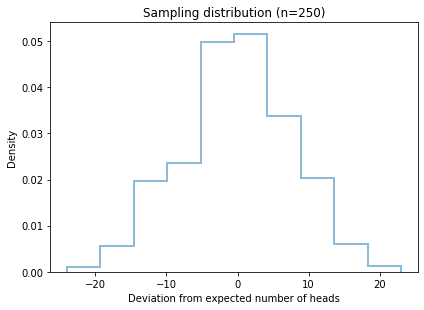

In [13]:
plot_hist(diffs)

plt.title('Sampling distribution (n=250)')
plt.xlabel('Deviation from expected number of heads');

This is the "sampling distribution" of deviations.  It shows how much variation we should expect between experiments with this sample size (n = 250).

## P-values

Getting get back to the Euro example, Dr. Bright reported:

"If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%".

The article doesn't say so explicitly, but this is a "p-value".  To understand what that means, let's count how many times, in 10000 attempts, the outcome is "as extreme as" the observed outcome, 140 heads.

The observed deviation is the difference between the observed and expected number of heads:

In [14]:
observed_diff = heads - expected
observed_diff

15.0

Let's see how many times the simulated `diffs` exceed the observed deviation:

In [15]:
np.mean(diffs >= observed_diff)

0.023

It's around 3%.  But Dr. Blight said 7%.  Where did that come from?

So far, we only counted the cases where the outcome is *more* heads than expected.  We might also want to count the cases where the outcome is *fewer* than expected.

Here's the probability of falling below the expected number by 15 or more.

In [16]:
np.mean(diffs <= -observed_diff)

0.031

To get the total probability of a result "as extreme as that", we can use the absolute value of the simulated differences:

In [17]:
np.mean(abs(diffs) >= observed_diff)

0.054

So that's consistent with what Dr. Blight reported.

To show what that looks like graphically, I'll use the following function, which fills in the histogram between `low` and `high`.

In [18]:
def fill_hist(low, high, patch):
    fill = plt.axvspan(low, high, 
                       clip_path=patch,
                       alpha=0.5, 
                       color='C0')

The following plot shows the sampling distribution of `diffs` with two regions shaded.  These regions represent the probability that an unbiased coin yields a deviation from the expected as extreme as 15.

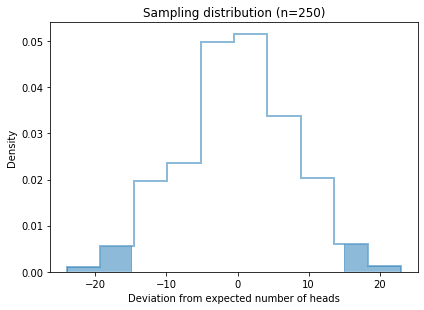

In [19]:
patch = plot_hist(diffs)

# fill the right tail of the hist
low = observed_diff
high = diffs.max()
fill_hist(low, high, patch)

# fill the left tail of the hist
low = diffs.min()
high = -observed_diff
fill_hist(low, high, patch)

plt.title('Sampling distribution (n=250)')
plt.xlabel('Deviation from expected number of heads')
plt.ylabel('Density');

These results show that there is a non-negligible chance of getting a result as extreme as 140 heads, even if the coin is actually fair.

So even if the results are "suspicious" they don't provide compelling evidence that the coin is biased.

**Exercise:** There are a few ways to make "crooked" dice, that is, dice that are more likely to land on one side than the others.  Suppose you run a casino and you suspect that a patron is using a die that comes up 3 more often than it should.  

You confiscate the die, roll it 300 times, and 63 times it comes up 3.  Does that support your suspicions?

- To answer this question, use `spin` to simulate the experiment, assuming that the die is fair.

- Use a for loop to run `spin` 1000 times and store the results in a NumPy array.

- What is the mean of the results from the simulated experiments?

- What is the expected number of 3s if the die is fair?

- Use `plot_hist` to plot the results.  The histogram you plot approximates the sampling distribution.

In [36]:
threes, other = 63, 237
samples = threes + other
prob = 1/6
spin(samples, prob)

47

In [37]:
outcomes = np.empty(1000)
for i in range(len(outcomes)):
    outcomes[i] = spin(samples, prob)

In [38]:
np.mean(outcomes)

49.86

In [39]:
expected = prob * samples
expected

50.0

Text(20.875, 0.5, 'Density')

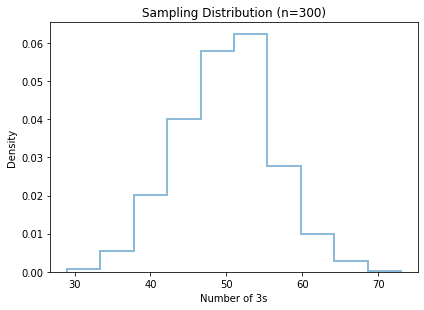

In [40]:
plot_hist(outcomes)
plt.title('Sampling Distribution (n=300)')
plt.xlabel('Number of 3s')
plt.ylabel('Density')

**Exercise:** Continuing the previous exercise, compute the probability of seeing a deviation from the expected value that is "as extreme" as the observed difference.

For this context, what do you think is the best definition of "as extreme"?

Plot the histogram of the random deviations again, and use `fill_hist` to fill the region of the histogram that corresponds to the p-value you computed. 

In [57]:
observed_diffs = threes - expected
diffs = outcomes - expected

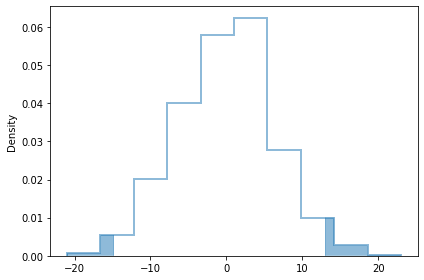

In [59]:
patch = plot_hist(diffs)

low = observed_diffs
high = diffs.max()
fill_hist(low, high, patch)

low = diffs.min()
high = -observed_diff
fill_hist(low, high, patch)

## Are first babies more likely to be late?

The examples so far have been based on coins and dice, which are relatively simple.  In this section we'll look at an example that's based on real-world data.

Here's the motivation for it: When my wife and I were expecting our first baby, we heard that first babies are more likely to be late.  We also hear that first babies are more likely to be early.  Neither claim was supported by evidence.

Fortunately, I am a data scientist!  Also fortunately, the CDC runs the National Survey of Family Growth (NSFG), which "gathers information on family life, marriage and divorce, pregnancy, infertility, use of contraception, and men’s and women’s health."

I got the data from their web page, https://www.cdc.gov/nchs/nsfg/index.htm, and wrote some code to get it into a Pandas Dataframe:

In [60]:
import os

if not os.path.exists('nsfg.hdf5'):
    !wget https://github.com/AllenDowney/ElementsOfDataScience/raw/master/nsfg.hdf5

--2020-03-11 13:38:51--  https://github.com/AllenDowney/ElementsOfDataScience/raw/master/nsfg.hdf5
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/nsfg.hdf5 [following]
--2020-03-11 13:38:52--  https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/nsfg.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.0.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 909832 (889K) [application/octet-stream]
Saving to: ‘nsfg.hdf5’

nsfg.hdf5           100%[===================>] 888.51K  --.-KB/s    in 0.08s   

2020-03-11 13:38:52 (10.4 MB/s) 

In [61]:
import pandas as pd

nsfg = pd.read_hdf('nsfg.hdf5')
nsfg.shape

(9358, 11)

The `nsfg` DataFrame contains 9358 rows, one for each recorded pregnancy, and 11 columns, one of each of the variables I selected.

Here are the first few lines.

In [62]:
nsfg.head()

,caseid,outcome,birthwgt_lb1,birthwgt_oz1,prglngth,nbrnaliv,agecon,agepreg,birthord,hpagelb,wgt2013_2015
0,60418,1,5.0,4.0,40,1.0,2000,2075.0,1.0,22.0,3554.964843
1,60418,1,4.0,12.0,36,1.0,2291,2358.0,2.0,25.0,3554.964843
2,60418,1,5.0,4.0,36,1.0,3241,3308.0,3.0,52.0,3554.964843
3,60419,6,NaN,NaN,33,NaN,3650,NaN,NaN,NaN,2484.535358
4,60420,1,8.0,13.0,41,1.0,2191,2266.0,1.0,24.0,2903.782914


The variables we need are `birthord`, which indicates birth order, and `prglength`, which is pregnancy length in weeks.

I'll make two boolean Series, one for first babies and one for others.

In [63]:
firsts = (nsfg.birthord == 1)
others = (nsfg.birthord > 1)

np.sum(firsts), np.sum(others)

(3067, 3422)

We can use the boolean Series to select pregnancy lengths for the two groups and compute their means:

In [64]:
prglngth = nsfg['prglngth']

mean_first = prglngth[firsts].mean() 
mean_other = prglngth[others].mean()

mean_first, mean_other

(38.57124225627649, 38.36908240794857)

Here's the difference in means, in weeks.

In [65]:
diff = mean_first - mean_other
diff

0.20215984832792344

Here it is converted to days:

In [66]:
diff * 7

1.415118938295464

It looks like first babies are born 1.4 days later than other babies, on average. 

## Hypothesis testing

The apparent difference between these groups is based on a random sample that is much smaller than the actual population.  So we can't be sure that the difference we see in the sample reflects a real difference in the population.  There are two other possibilities we should keep in mind:

*  Systematic errors: The sample might be more likely to include some pregancies, and less likely to include others, in a way that causes an apparent difference in the sample, even if there is no such difference in the population.

*  Sampling errors: Even if every pregnancy is equally likely to appear in the sample, it is still possible to see a difference in the sample that is not in the population, just because of random variation.

We can never rule out the possibility of systematic errors, but we *can* test whether an apparent effect could be explained by random sampling.

Here's how:

1. First we choose a "test statistic" that measures the size of the effect; the test statistic in this example is the difference in mean pregnancy length.

2. Next we define a model of the population under the assumption that there is actually no difference between the groups.  This assumption is called the "null hypothesis".

3. Then we use the model to compute the distribution of the test statistic under the null hypothesis.

We have already done step 1, but to make it easier to repeat, I'll wrap it in a function.

In [67]:
def test_stat(group1, group2):
    """Difference in means.
    
    group1: sequence of values
    group2: sequence of values
    
    returns: float difference in means
    """
    diff = np.mean(group1) - np.mean(group2)
    return diff

`test_stat` takes two sequences and computes the difference in their means.

Here's how we use it to compute the actual difference in the sample.

In [68]:
group1 = prglngth[firsts]
group2 = prglngth[others]

actual_diff = test_stat(group1, group2)
actual_diff

0.20215984832792344

Now we have to define the null hypothesis, which is a model of the world where there is no difference in pregnancy length between first babies and others.

One way to do that is to put the two groups together and then divide them up again at random.  That way the distribution of pregnancy lengths is the same for both groups.

I'll use `concatenate` to pool the groups. 

In [69]:
len(group1), len(group2)

(3067, 3422)

In [70]:
pool = np.concatenate([group1, group2])
pool.shape

(6489,)

I'll use `shuffle` to reorder them.

In [71]:
np.random.shuffle(pool)

Then I'll use `split` to make two simulated groups, the same size as the originals.

In [72]:
n = len(group1)
sim_group1, sim_group2 = np.split(pool, [n])

In [73]:
len(sim_group1), len(sim_group2)

(3067, 3422)

Now we can compute the test statistic for the simulated data.

In [74]:
test_stat(sim_group1, sim_group2)

0.053154781857053024

In the simulated data, the distribution of pregnancy lengths is the same for both groups, so the difference is usually close to 0.

But because it is based on a random shuffle of the groups, we get a different value each time we run it.

To see what the whole distribution looks like, we can run the simulation many times and store the results.

In [75]:
diffs = np.empty(1000)

for i in range(len(diffs)):
    np.random.shuffle(pool)
    sim_group1, sim_group2 = np.split(pool, [n])
    diffs[i] = test_stat(sim_group1, sim_group2)

The result is the "sampling distribution of the test statistic under the null hypothesis".

The mean of this distribution should close to zero, because it is based on the assumption that there is actually no difference between the groups.

In [76]:
np.mean(diffs)

-0.001087390286332564

And here's what the whole distribution looks like.

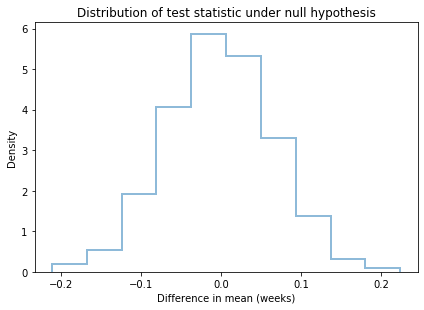

In [77]:
plot_hist(diffs)

plt.xlabel('Difference in mean (weeks)')
plt.title('Distribution of test statistic under null hypothesis');

If there were actually no difference between the groups, we would expect to see a difference as big as 0.15 weeks by chance, at least occasionally.  But a difference as big as 0.2 would be rare.

To quantify that surprise, we can estimate the probability that the test statistic, under the null hypothesis, exceeds the observed differences in the means.

The result is a "p-value".

In [78]:
p_value = np.mean(diffs >= actual_diff)
p_value

0.003

In this example the result is 0, which is to say that in 1000 simulations of the null hypothesis, we never saw a difference as big as 0.2.

## Interpreting p-values

To interpret this result, remember that we started with three possible explanations for the observed difference between the groups:

1. The observed difference might be "real"; that is, there might be an actual difference in pregnancy length between first babies and others.

2. There might be no real difference between the groups, and the observed difference might be because of a systematic error in the sampling process or the data collection process.  For example, maybe reported pregnancy lengths are less accurate for first time mothers.

3. There might be no real difference between the groups, and the observed difference might be due to random variation in the sampling process.

By computing a p-value, we have established that it would be rare to see a difference as big as 0.2 due to sampling alone.  So we can conclude that the third explanation is unlikely.

That makes it more likely that the difference is real, but we still can't rule out the second possibility.

**Exercise:** The test statistic we chose is the difference in means between the two groups.

But suppose we would like to know whether first babies are more unpredictable than other babies.  In that case the test statistic we choose might be the standard deviation of pregnancy length, which is one way to quantify unpredictability.

As an exercise:

1. Write a version of `test_stat` that computes the difference in standard deviation between the groups.

2. Write a loop that estimates the distribution of this test statistic under the null hypothesis.

3. Compute a p-value.

In [131]:
def test_stat(group1, group2):
    """Computes the difference in standard deviation between the groups.
    
    group1: sequence of values
    group2: sequence of values
    
    returns: float difference in standard deviation
    """
    diff = group1.std() - group2.std()
    return diff

Finding Standard Deviation Manually: 
1. Find the mean result, the expected
2. Find the variance: Subtract the mean from each of the numbers, square the numbers, add them together, divide the sum of the squares my (n-1)
4. Standard deviation = sqrt(variance)

In [132]:
group1 = prglngth[firsts]
group2 = prglngth[others]

In [133]:
group1.std()

2.7286013544072696

In [134]:
group2.std()

2.557314304298131

In [138]:
std = test_stat(group1, group2)
std

0.17128705010913858

In [139]:
pool = np.concatenate([group1, group2])
pool.shape

(6489,)

In [140]:
diffs = np.empty(1000)
for i in range(len(diffs)):
    np.random.shuffle(pool)
    sim_group1, sim_group2 = np.split(pool, [n])
    diffs[i] = test_stat(sim_group1, sim_group2)

In [141]:
np.mean(diffs)

0.0004912676179112485

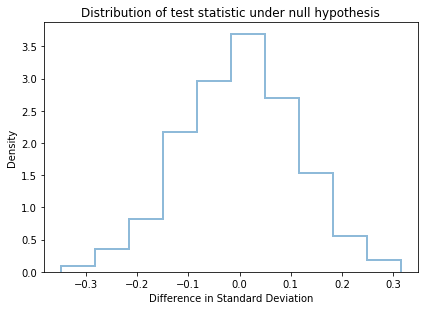

In [142]:
plot_hist(diffs)

plt.xlabel('Difference in Standard Deviation')
plt.title('Distribution of test statistic under null hypothesis');

In [143]:
p_value = np.mean(diffs >= actual_diff)
p_value

0.059

Based on this information and data, it cannot be confidently concluded that first born babies are more unpredictable in pregnancy time than other babies. The p value of the standard variance under the null hypothesis is 5.9%, showing rather large variance. 

The difference in standard deviation between first born babies and other babies is not outside the realm of random sampling of the whole dataset.

## Estimation

Suppose we want to estimate the average height of men in the U.S.

We can use data from the [BRFSS](https://www.cdc.gov/brfss/index.html):

"The Behavioral Risk Factor Surveillance System (BRFSS) is the nation's premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services."

In [ ]:
# Get the data file

import os

if not os.path.exists('brfss.hdf5'):
    !wget https://github.com/AllenDowney/ElementsOfDataScience/raw/master/brfss.hdf5

In [ ]:
import pandas as pd

brfss = pd.read_hdf('brfss.hdf5', 'brfss')
brfss.shape

We can use `SEX` to select male respondents.

In [ ]:
male = (brfss.SEX == 1)
np.mean(male)

Then we select height data.

In [ ]:
heights = brfss['HTM4']
data = heights[male]

We can use `isnan` to check for NaN values:

In [ ]:
np.mean(np.isnan(data)) * 100

About 4% of the values are missing.

Here are the mean and standard deviation, ignoring missing data.

In [ ]:
print('Mean male height in cm =', np.nanmean(data))
print('Std male height in cm =', np.nanstd(data))

## Quantifying precision

At this point we have an estimate of the average adult male height.  We'd like to know how accurate this estimate is, and how precise.  In the context of estimation, these words have a [technical distinction](https://en.wikipedia.org/wiki/Accuracy_and_precision):

>Given a set of data points from repeated measurements of the same quantity, the set can be said to be precise if the values are close to each other, while the set can be said to be accurate if their average is close to the true value of the quantity being measured.

Usually accuracy is what we really care about, but it's hard to measure accuracy unless you know the true value.  And if you know the true value, you don't have to estimate it.

Quantifying precision is not as useful, but it is much easier.  Here's one way to do it:

1.  Use the data you have to make a model of the population.

2.  Use the model to simulate the data collection process.

3.  Use the simulated data to compute an estimate.

By repeating these steps, we can quantify the variability of the estimate due to random sampling.

To model the population, I'll use **resampling**; that is, I will treat the observed measurements as if they were taken from the entire population, and I will draw random samples from them.

We can use `np.random.choice` to resample the data:

In [ ]:
size = len(data)
sim_data = np.random.choice(data, size, replace=True)
sim_data.shape

With `replace=True`, we sample with replacement, which means that some measurements might be chosen more than once, and some might not be chosen at all.

(If we sample *without* replacement, the resampled data is always identical to the original, so that's no good.)

Now we can use `nanmean` to compute the mean of the simulated data, ignoring missing values.

In [ ]:
np.nanmean(sim_data)

If we repeat this process 1000 times, we can see how much the results vary.

In [ ]:
outcomes = np.empty(1000)
size = len(data)

for i in range(len(outcomes)):
    sim_data = np.random.choice(data, size, replace=True)
    outcomes[i] = np.nanmean(sim_data)

The result is the "sampling distribution", which shows how much the results of the experiment would vary if we ran it many times.  Here's what it looks like:

In [ ]:
plot_hist(outcomes)
plt.title('Sampling distribution of the mean')
plt.xlabel('Mean adult male height, U.S.');

The width of this distribution shows how much the results vary from one experiment to the next.

We can quantify this variability by computing the standard deviation of the sampling distribution, which is called "standard error".


In [ ]:
std_err = np.std(outcomes)
std_err

We can also summarize the sampling distribution with a "confidence interval", which is a range that contains a specified fraction, like 90%, of the values in `sampling_dist_mean`.

The central 90% confidence interval is between the 5th and 95th percentiles of the sampling distribution.

In [ ]:
ci_90 = np.percentile(outcomes, [5, 95])
ci_90

The following function plots a histogram and shades the 90% confidence interval.

In [ ]:
def plot_sampling_dist(outcomes):
    patch = plot_hist(outcomes)
    low, high = np.percentile(outcomes, [5, 95])
    fill_hist(low, high, patch)
    print('Mean = ', np.mean(outcomes))
    print('Std error = ', np.std(outcomes))
    print('90% CI = ', (low, high))

Here's what it looks like for the sampling distribution of mean adult height:

In [ ]:
plot_sampling_dist(outcomes)
plt.xlabel('Mean adult male height, U.S. (%)');

For an experiment like this, we can compute the standard error analytically.

In [ ]:
size = len(data)
analytic_std_err = np.std(data) / np.sqrt(size)

The result is close to what we observed computationally.

In [ ]:
analytic_std_err, std_err

This result indicates that our estimate of the mean is *precise*; that is, if we ran this experiment many times, the results would fall in a narrow range.

But this range reflects only variability due to random sampling.  If there are systematic errors in the sampling process, or in the measurement process, the result would not be *accurate*.

Computing a standard error or confidence interval can be useful, but it only quantifies variability due to random sampling, not other sources of error.

**Exercise:** One nice thing about using resampling is that it is easy to compute the sampling distribution for other statistics.

For example, suppose we want to estimate the coefficient of variation (standard deviation as a fraction of the mean) for adult male height.  Here's how we can compute it.

In [ ]:
cv = np.nanstd(data) / np.nanmean(data)
cv

So the standard deviation is about 5% of the mean. 

Write a loop that uses resampling to estimate the sampling distribution of `cv`; store the results in an array named `outcomes`.

Then use `plot_sampling_dist` to plot the sampling distribution of the coefficient of variation.

What is the standard error of the estimated coefficient of variation?

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

## Summary

This notebook presents computational methods for computing p-values, standard errors, and confidence intervals.  The two processes are similar, but they answer different questions.

The following diagram outlines the hypothesis testing process:

<img src="https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/hypothesis_testing.png" width="400">


Again, the key steps are

1. Choose a test statistic that quantifies the observed effect.

2. Define a model of the null hypothesis and use it to generate simulated data.

3. Compute the distribution of the test statistic under the null hypothesis.

4. Compute a p-value, which is probability, under the null hypothesis, of seeing an effect as extreme as what you saw.

The following figure shows the similar process for computing standard errors and confidence intervals.

<img src="https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/resampling.png" width="400">


The essential steps are:

1. Choose a sample statistic that quantifies the thing you want to estimate.

2. Use the data to make a model of the population, assuming that the estimate is accurate.

3. Use the model to simulate the sampling process and generate simulated data.

4. Compute the sampling distribution of the estimate.

5. Use the sampling distribution to compute the standard error, confidence interval, or both.

Finally, remember that both processes only account for variability due to random sampling.  They don't tell us anything about systematic errors in the sampling process, measurement error, or other sources of error.